In [15]:
from tensorflow import data
from tensorflow import keras
from keras import layers
from keras.datasets import cifar10
from keras.callbacks import ReduceLROnPlateau
import keras_tuner as kt

import matplotlib.pyplot as plt
import numpy as np
import torch
import time

## Load Custom Dataset

Found 120 files belonging to 3 classes.
Using 18 files for validation.
Found 120 files belonging to 3 classes.
Using 18 files for validation.
Found 120 files belonging to 3 classes.
Using 84 files for training.


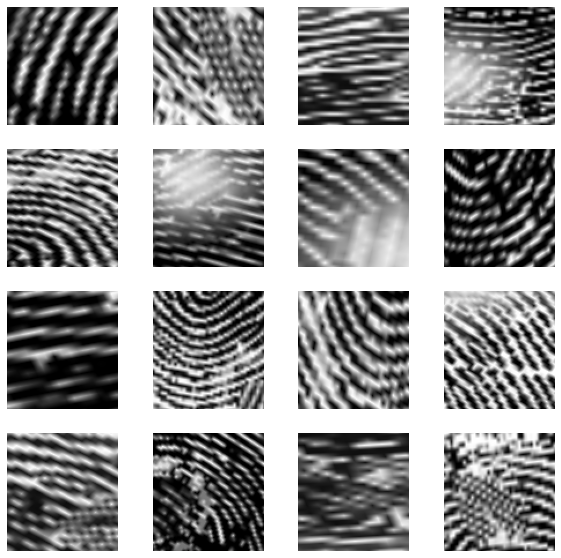

In [128]:
DATASET_SIZE = 120

directory = "./DemoDataset"

test_data = keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(103, 96),
    shuffle=True,
    seed=7,
    validation_split=0.15,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

val_data = keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(103, 96),
    shuffle=True,
    seed=7,
    validation_split=0.15,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

train_data = keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(103, 96),
    shuffle=True,
    seed=7,
    validation_split=0.3,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

# Use ImageDataGenerator to rescale, rotate, and flip the images
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    # rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0.2,
    zoom_range=[0.1, 0.4],
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    samplewise_center=False,
    samplewise_std_normalization=False,
    fill_mode="constant",
    cval=255,
)

# display some images from the training set to see the augmentation
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):

    for i in range(16):
        augmented_images = train_datagen.flow(images, batch_size=1)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_images[0][0].astype("uint8"))
        plt.axis("off")



val_datagen = keras.preprocessing.image.ImageDataGenerator(
    # rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0.2,
    zoom_range=[0.1, 0.4],
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    samplewise_center=False,
    samplewise_std_normalization=False,
    fill_mode="constant",
    cval=0,
)

# augment the data set
train_ub = train_data.unbatch()
train_images = list(train_ub.map(lambda x, y: x))
train_labels = list(train_ub.map(lambda x, y: y))

train_images = np.array(train_images)
train_labels = np.array(train_labels)

train_datagen.fit(train_images)

val_ub = val_data.unbatch()
val_images = list(val_ub.map(lambda x, y: x))
val_labels = list(val_ub.map(lambda x, y: y))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

val_datagen.fit(val_images)


In [102]:
test_model = keras.applications.DenseNet121(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(103, 96, 3),
    pooling='max',
    classes=3,
    classifier_activation="softmax"
)

# test_model = keras.Sequential()
# test_model.add(layers.Flatten(input_shape=(103, 96, 3)))
# test_model.add(layers.Dense(128, activation='relu', input_shape=(103, 96, 3)))
# test_model.add(layers.Dense(3, activation='softmax'))

# Compile the model
test_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)

# Train the model
test_model.fit(train_data, epochs=100, validation_data=val_data, callbacks=[reduce_lr])

# Evalutate the model
test_model.evaluate(test_data)

Epoch 1/100
5/5 [==============================] - 9s 640ms/step - loss: 3.1251 - accuracy: 0.3571 - val_loss: 156888779980800.0000 - val_accuracy: 0.3889 - lr: 0.0100
Epoch 2/100
5/5 [==============================] - 2s 397ms/step - loss: 1.2443 - accuracy: 0.6905 - val_loss: 6745787510405726208.0000 - val_accuracy: 0.2778 - lr: 0.0100
Epoch 3/100
5/5 [==============================] - 2s 396ms/step - loss: 0.8271 - accuracy: 0.5238 - val_loss: 2418801336293261312.0000 - val_accuracy: 0.3333 - lr: 0.0100
Epoch 4/100
5/5 [==============================] - 2s 397ms/step - loss: 0.8317 - accuracy: 0.6786 - val_loss: 18287629296467968.0000 - val_accuracy: 0.3333 - lr: 0.0100
Epoch 5/100
5/5 [==============================] - 2s 391ms/step - loss: 0.6147 - accuracy: 0.6786 - val_loss: 490931874693120.0000 - val_accuracy: 0.3333 - lr: 0.0100
Epoch 6/100
5/5 [==============================] - 2s 392ms/step - loss: 0.5420 - accuracy: 0.7500 - val_loss: 743568900096.0000 - val_accuracy: 0.333

[0.05042354762554169, 0.9444444179534912]

## Training Models with Augmented Datasets

In [129]:

test_model = keras.applications.DenseNet121(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(103, 96, 3),
    pooling='max',
    classes=3,
    classifier_activation="softmax"
)

# test_model = keras.Sequential()
# test_model.add(layers.Flatten(input_shape=(103, 96, 3)))
# test_model.add(layers.Dense(128, activation='relu', input_shape=(103, 96, 3)))
# test_model.add(layers.Dense(3, activation='softmax'))

# Compile the model
test_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.000001)

# Train the model
test_model.fit(
        (train_datagen.flow(train_images, train_labels, batch_size=32)), 
        validation_data=(val_datagen.flow(val_images, val_labels, batch_size=8)),
        callbacks=[],
        epochs=1500,
        )

# Evalutate the model
test_model.evaluate(test_data)

Epoch 1/1500
3/3 [==============================] - 9s 1s/step - loss: 3.0830 - accuracy: 0.3333 - val_loss: 1879338496.0000 - val_accuracy: 0.3333
Epoch 2/1500
3/3 [==============================] - 2s 625ms/step - loss: 2.2672 - accuracy: 0.3095 - val_loss: 508125165649920.0000 - val_accuracy: 0.3333
Epoch 3/1500
3/3 [==============================] - 2s 723ms/step - loss: 1.9703 - accuracy: 0.3214 - val_loss: 4119419544387190784.0000 - val_accuracy: 0.2778
Epoch 4/1500
3/3 [==============================] - 2s 730ms/step - loss: 1.7000 - accuracy: 0.3333 - val_loss: 23384468275121356800.0000 - val_accuracy: 0.3333
Epoch 5/1500
3/3 [==============================] - 2s 624ms/step - loss: 1.6745 - accuracy: 0.3452 - val_loss: 8824495606576709632.0000 - val_accuracy: 0.2778
Epoch 6/1500
3/3 [==============================] - 2s 716ms/step - loss: 1.3432 - accuracy: 0.3690 - val_loss: 1581822986099359744.0000 - val_accuracy: 0.2778
Epoch 7/1500
3/3 [==============================] - 2s 

[724.7985229492188, 0.2222222238779068]